In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import zipfile
from tensorflow.keras.models import model_from_json
import tqdm
import h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*75)]#x.shape[2])]

In [4]:
def cut(x, switch):
    temp = []
    size = int(x.shape[0] / 5)
    for i in range(5):
        temp.append(x[i * size:(i + 1) * size])
    x = np.array(temp)
    
    if switch:
        x = np.reshape(x, (5,-1))
    
    return x

In [5]:
os.chdir("../Data/Re15sh20_DNScoarse8")
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"]))
tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"]))

In [6]:
all_taus = False
significance = True

### Create Datasets

In [7]:
x = np.array([u, v, w])
#tke, theta])
x = np.transpose(x, [1, 2, 3, 0])
#x = np.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
print(x.shape)
x = cut(x, False)
print(x.shape)

(146, 96, 56, 3)
(5, 29, 96, 56, 3)


In [8]:
tau_12 = cut(tau_12, False)#np.reshape(tau_12, (1, -1))
print(tau_12.shape)
tau_13 = cut(tau_13, False)#np.reshape(tau_13, (1, -1))
print(tau_12.shape)
tau_23 = cut(tau_23, False)#np.reshape(tau_23, (1, -1))
print(tau_23.shape)

(5, 29, 96, 56)
(5, 29, 96, 56)
(5, 29, 96, 56)


### Create Model Class 

In [9]:
class CNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split, x_val, y_val):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.filter = filter_size
        self.val_split = val_split
        self.x_val = x_val
        self.y_val = y_val
        
        pass         
    
    def create_model(self):    
        model = keras.Sequential([
            tf.keras.layers.Conv3D(128,
                             kernel_size = self.filter,
                             activation = self.activation,
                             input_shape = input_shape,   
                             padding = "same",
                             kernel_regularizer = self.regularizer,
                             data_format = 'channels_last'),
            tf.keras.layers.AveragePooling3D(pool_size = (29,96,56)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.y_train.shape[1])
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
        model.summary()
            
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    #validation_split = self.val_split, 
                    validation_data = (self.x_val, self.y_val),
                    batch_size =  self.batch_size,
                    verbose = 1)
                    #callbacks = [self.callbacks()])
        
        return history, model

###  Compare TKE, $\theta$ and Base

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 29, 96, 56, 128)   131840    
_________________________________________________________________
average_pooling3d (AveragePo (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

4/4 [==============================] - 5s 1s/step - loss: 1.0464 - val_loss: 1.5172
Epoch 27/50
4/4 [==============================] - 5s 1s/step - loss: 1.0408 - val_loss: 1.5752
Epoch 28/50
4/4 [==============================] - 5s 1s/step - loss: 0.9761 - val_loss: 1.6385
Epoch 29/50
4/4 [==============================] - 5s 1s/step - loss: 1.0211 - val_loss: 1.6400
Epoch 30/50
4/4 [==============================] - 5s 1s/step - loss: 0.9794 - val_loss: 1.5985
Epoch 31/50
4/4 [==============================] - 5s 1s/step - loss: 0.9765 - val_loss: 1.5955
Epoch 32/50
4/4 [==============================] - 5s 1s/step - loss: 0.9790 - val_loss: 1.6179
Epoch 33/50
4/4 [==============================] - 5s 1s/step - loss: 0.9922 - val_loss: 1.6412
Epoch 34/50
4/4 [==============================] - 5s 1s/step - loss: 1.0369 - val_loss: 1.6489
Epoch 35/50
4/4 [==============================] - 5s 1s/step - loss: 1.0296 - val_loss: 1.6319
Epoch 36/50
4/4 [==============================] - 5

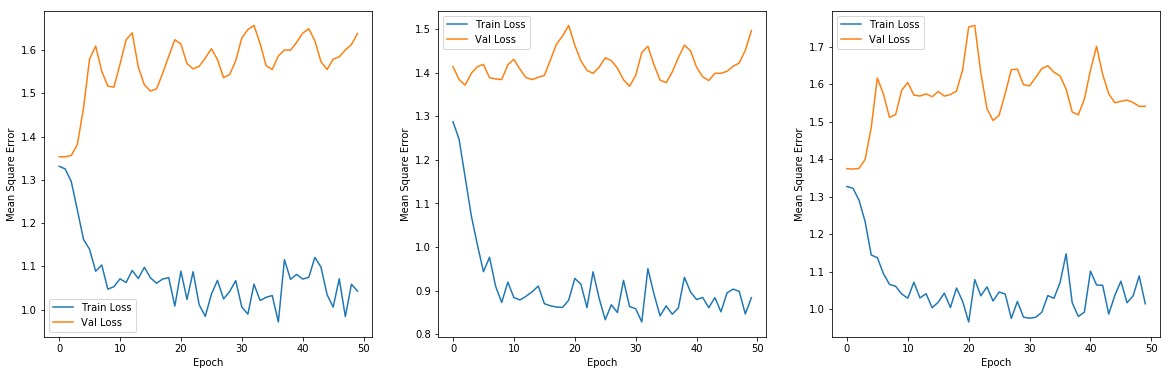

NameError: name 'datasets' is not defined

In [10]:
if significance:
    activation = tf.nn.relu
    initializer = None
    regularizer = None
    epochs = 50
    batch_size = 1
    filter_size = (7,7,7)
    val_split = 0.0

    fig = plt.figure(figsize = (20, 6))
    results = {}
    i = 1
    x_train, x_val = x[1:], x[0]
    x_val = x_val.reshape((1, x_val.shape[0], x_val.shape[1], x_val.shape[2], x_val.shape[3]))
    
    y_datasets = [tau_12, tau_13, tau_23]
    for y_dataset in y_datasets:
        y_train, y_val = y_dataset[1:], y_dataset[0]
        y_train = y_train.reshape((4, -1))
        y_val = y_val.reshape((1, -1))

        input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
        model = CNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split, x_val, y_val)
        history, model = model.run_model()

        fig.add_subplot(1, 3, i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.legend()

        y_pred = model.predict(x_train).flatten()
        y_true = y_train.flatten()
        print("R^2: %.4f" % r2_score(y_true, y_pred))
        print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
        results[np.corrcoef(y_pred, y_true)[0, 1]] = x
        
        del y_train
        del y_val
        del model
        del y_pred
        del y_true
        gc.collect()
        i = i + 1
        
    plt.show()
    
    del x_train
    del x_val
    gc.collect()